In [1]:
from bandit_e import BMO_E

from itertools import product
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt

class cube:
    def __init__(self, x, ys, xs, cube_length, d=1, reward=0):
        '''
        Parameters
        ----------
        x : TYPE: list or numpy.array
            'bottom left' point of initial cube, 
            'bottom left' means the coordinates of other points in the cube are not less than this point
            for example: the 'bottom left' point of cube [(0,0),(1,0),(0,1),(1,1)] is (0,0)
        cube_length : TYPE: float
            edge length of cube
        d : TYPE, int
            dimension of cube
        reward: TYPE, float
            mean reward of the cube
        '''
        self.x = x
        self.cube_length = cube_length
        self.d = d
        self.ys = ys
        self.xs = xs       
        self.children = []
        
        
    def split(self):
        '''split by dyadic'''
        new_cube_length = self.cube_length / 2
        candidate_idx = np.array(list(product([0,1], repeat=self.d)))
        for idx in candidate_idx:
            new_x = self.x + idx * new_cube_length
            if not np.array(self.xs).any():
                new_cube = cube(new_x, [], [], new_cube_length)
            else:
                new_xs, new_ys = self.update_xy(self.xs, self.ys, new_x, new_cube_length)
                new_cube = cube(new_x, new_ys, new_xs, new_cube_length)
            new_cube.parent = self
            self.children.append(new_cube)
        return self.children
    
    
    def insert_point(self, x, y):
        if (x >= self.x).all() and (x <= (self.x+self.cube_length)).all():
            self.xs.append(x)
            self.ys.append(y)
    

        
        
        
    def update_xy(self, parent_xs, parent_ys, child_x, child_cube_length):
        xs = np.array(parent_xs).copy()
        ys = np.array(parent_ys).copy()
        condition = ((xs >= child_x) & (xs <= child_x + child_cube_length)).all(axis=1)
        try:
            return xs[condition], ys[condition]
        except:
            print(child_x)
            print(ys.shape)
    
    
    
    def mean_reward(self):
        return np.mean(self.ys)
        
        

            
        
class BMO_E:
    def __init__(self, T, init_x, init_cube_length, eta, epsilon, delta, c, data, split_times=1):
        '''
        Parameters
        ----------
        B : TYPE: int
            total batch number
        init_x : TYPE: list or numpy.array
            'bottom left' point of initial cube, 
            'bottom le8ft' means the coordinates of other points in the cube are not less than this point
            for example: the 'bottom left' point of cube [(0,0),(1,0),(0,1),(1,1)] is (0,0)
        init_cube_length :TYPE: float
            edge length of initial cube

        '''
        
        self.init_cubes = [cube(np.array(init_x), [], [], init_cube_length)]
        #self.regrets = []  #regret list of each batch
        self.T = T   #time horizon
        self.s_cubes = []  #cubes surviving each batch
        self.cubes = []    #cubes played each batch
        self.count = 0     #number of times arm has been played
        self.eta = eta
        self.epsilon = epsilon
        self.delta = delta
        self.regrets = []   #regret list
        self.cur_regret = 0  #current regret
        self.rewards = []
        self.arms = []
        self.delta_regret = 0
        self.split_times = split_times
        self.c = c
        self.tmp = []
        self.data = data
        self.c_scale = 6

        
    
    def initialize(self):
        
        # calcalate f_delta
#         print('------initialize--------')
#         print('get f_delta:')
        self.delta_regret = np.quantile(self.data, 1-self.delta) * self.c_scale
        self.m_regret = np.max(self.data) * self.c_scale
        
        
#         print('----play batch 0 ------')
        cubes = self.init_cubes
        for i in range(self.split_times):
            cubes = self.partition(cubes)
        self.cubes.append(cubes)
        
        nb, Hb = self.values4batch()
#         print('Hb', Hb)
        self.play_one_batch(cubes, nb)
#         print('have play {} times totally'.format(self.count))
        
        s_cubes = self.elimination(cubes, Hb)
        self.s_cubes.append(s_cubes)
        
        
          
    def values4batch(self):
        '''
        get some values related to batch
        
        Returns
        -------
        nb : playtimes of batch
        Hb : Hoeffding bound of batch
        '''
        phi = np.max([np.log(self.T**2/self.epsilon), 2*np.log2(1/self.eta)])
        denominator = phi * np.sqrt(2*np.log(2*self.T**2/self.epsilon))
        
#         denominator = np.sqrt(np.log(self.T/self.epsilon))
        
        cube_length = self.cubes[-1][-1].cube_length
        d = self.cubes[-1][-1].d
        mu_cube = pow(cube_length, d)
        numerator = self.c * np.log(mu_cube/self.eta)
        
        nb_sqrt = np.floor(denominator / numerator)
        
        nb = pow(nb_sqrt, 2)
#         print(nb)
        Hb = denominator / np.sqrt(nb)
#         print('Hb', Hb)
        
        return int(nb), Hb
        
        
    def partition(self, cubes):
        '''
        cubes: list of cubes to be split
        '''
        new_cubes = []
        for cube in cubes:
            new_cubes_ = cube.split()
            new_cubes += new_cubes_
        return new_cubes
    
    
    
    def play_one_batch(self, cubes, nb):
#         print('every cube need to be played {} times this batch'.format(nb))
        
        for cube in cubes:
            cube_nb = max(0, nb - len(cube.xs))
            for t in range(cube_nb):
                cube_nb = max(0, nb - len(cube.xs))
                self.count += 1
                if self.count > self.T:
                    break
                arm = self.sample(cube)
                self.arms.append(arm)
                observation, reward = self.get_reward(arm)
                cube.xs = list(cube.xs) + [arm]
                cube.ys = list(cube.ys) + [observation]
                
                self.cur_regret += max(self.delta_regret - reward, 0)
                self.regrets.append(self.cur_regret)
                self.rewards.append(reward)
                
            if self.count > self.T:
                break
                
                

        
            
    def elimination(self, cubes, Hb):
        rewards = [cube.mean_reward() for cube in cubes]
        max_reward = np.max(rewards)
        rewards_diff = max_reward - rewards
        s_cubes_idx = np.where(rewards_diff <= (2+1/self.c)*Hb)[0]
        s_cubes = [cubes[idx] for idx in s_cubes_idx]
        return s_cubes
                
        
    def sample(self, cube):
        arm = np.random.uniform(cube.x, cube.x+cube.cube_length)
        return arm
        
    
    def get_reward(self, arm):
        '''  get function value of arm
        function: bmo function in [-1, 1]
        arm: shape (1, 1) in this example
        '''
        x = arm[0]
        x = int(np.floor(x*len(self.data)))
        reward = self.data[x]
        reward = reward * self.c_scale
        observation = np.random.normal(reward, 0.1)
        return observation, reward

    
    
    def play(self):
        self.initialize()
        for b in range(1, self.T):
#             print('----play batch {} ------'.format(b))
            cubes = self.partition(self.s_cubes[-1])
            if self.count > self.T:
                break
                
            
            self.cubes.append(cubes)
            nb, Hb = self.values4batch()
#             print('Hb', Hb)

            self.play_one_batch(cubes, nb)
#             print('have play {} times totally'.format(self.count-1))
            
            s_cubes = self.elimination(cubes, Hb)
            self.s_cubes.append(s_cubes)
            
            
    def plot(self):
        self.play()
        scale_rewards = self.rewards
        delta_regret = self.delta_regret
        m_regret = self.m_regret
        #scale_rewards = [(np.log(reward*8000) - 8.693) / 2.427 for reward in self.rewards]
        #delta_regret = (np.log(self.delta_regret*8000) - 8.693) / 2.427
        scale_regrets = [max(0, delta_regret - reward) for reward in scale_rewards]
        regrets = [(m_regret - reward) for reward in scale_rewards]
        #plt.plot(np.cumsum(scale_regrets))
        #plt.plot(np.cumsum(regrets))
        #plt.show()

        print('cubes num:', [len(cubes) for cubes in self.cubes])
        print('s_cubes num:', [len(cubes) for cubes in self.s_cubes])
        
        return scale_regrets, regrets


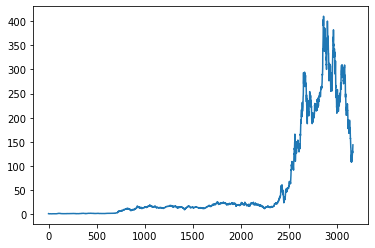

In [2]:
import pandas as pd
df = pd.read_csv('../TSLA.csv')
plt.plot(df['Adj Close'])
plt.show()

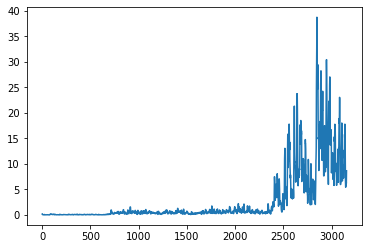

In [3]:
windows = 10
data = df['Adj Close'].rolling(windows).std()[windows-1:].values
plt.plot(data)
plt.show()

In [4]:
T = 10000
init_x = [0]
init_cube_length = 1
eta = 1e-4
epsilon = 1e-2
delta = 1e-3
c = 6
split_times = 2

regrets_all = []
regrets_delta_all = []
for _ in range(10):
    A = BMO_E(T, init_x, init_cube_length, eta, epsilon, delta, c, data, split_times=split_times)
    regrets_delta, regrets = A.plot()
    regrets_all.append(regrets)
    regrets_delta_all.append(regrets_delta)

cubes num: [4, 8, 16, 32, 14, 22, 12, 4, 4, 2, 4, 6]
s_cubes num: [4, 8, 16, 7, 11, 6, 2, 2, 1, 2, 3, 3]
cubes num: [4, 8, 16, 32, 14, 22, 10, 4, 4, 2, 4, 6]
s_cubes num: [4, 8, 16, 7, 11, 5, 2, 2, 1, 2, 3, 3]
cubes num: [4, 8, 16, 32, 16, 22, 12, 4, 4, 2, 4, 6]
s_cubes num: [4, 8, 16, 8, 11, 6, 2, 2, 1, 2, 3, 3]
cubes num: [4, 8, 16, 32, 16, 22, 8, 2, 4, 2, 4, 6]
s_cubes num: [4, 8, 16, 8, 11, 4, 1, 2, 1, 2, 3, 3]
cubes num: [4, 8, 16, 32, 14, 22, 10, 2, 4, 2, 4, 6]
s_cubes num: [4, 8, 16, 7, 11, 5, 1, 2, 1, 2, 3, 3]
cubes num: [4, 8, 16, 32, 14, 24, 20, 6, 4, 2, 4, 6]
s_cubes num: [4, 8, 16, 7, 12, 10, 3, 2, 1, 2, 3, 3]
cubes num: [4, 8, 16, 32, 14, 22, 12, 6, 4, 2, 4, 6]
s_cubes num: [4, 8, 16, 7, 11, 6, 3, 2, 1, 2, 3, 3]
cubes num: [4, 8, 16, 32, 16, 24, 30, 6, 6, 2, 4, 6]
s_cubes num: [4, 8, 16, 8, 12, 15, 3, 3, 1, 2, 3, 3]
cubes num: [4, 8, 16, 32, 14, 20, 8, 2, 4, 2, 4, 6]
s_cubes num: [4, 8, 16, 7, 10, 4, 1, 2, 1, 2, 3, 3]
cubes num: [4, 8, 16, 32, 16, 24, 22, 2, 4, 2, 4, 6]
s_

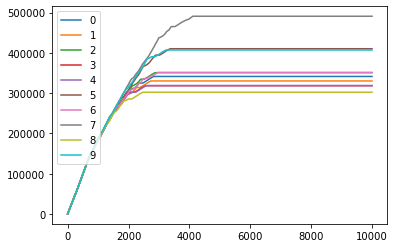

In [5]:
import matplotlib.pyplot as plt
import numpy as np
# for i in range(10):
#     plt.plot(np.cumsum(regrets_all, axis=1)[i], label='{}'.format(i))
# plt.legend()
# plt.show()

for i in range(10):
    plt.plot(np.cumsum(regrets_delta_all, axis=1)[i], label='{}'.format(i))
plt.legend()
plt.show()

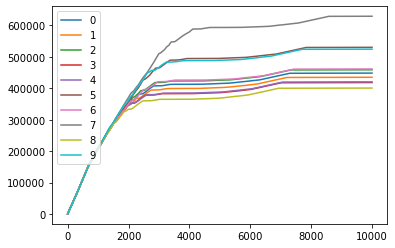

In [6]:
for i in range(10):
    plt.plot(np.cumsum(regrets_all, axis=1)[i], label='{}'.format(i))
plt.legend()
plt.show()

In [7]:
regret_m = np.mean(np.cumsum(regrets_all, axis=1), axis=0)
regret_std = np.std(np.cumsum(regrets_all, axis=1), axis=0)
regret_m_delta = np.mean(np.cumsum(regrets_delta_all, axis=1), axis=0)
regret_std_delta = np.std(np.cumsum(regrets_delta_all, axis=1), axis=0)

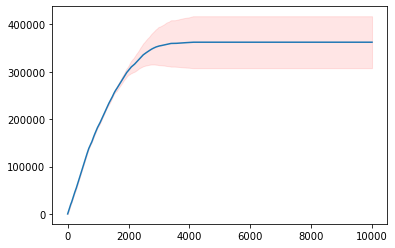

In [8]:
import matplotlib.pyplot as plt
# plt.plot(regret_m)
plt.plot(regret_m_delta)
# plt.fill_between(np.array(range(len(regret_m))), 
#                  regret_m - regret_std, regret_m + regret_std, alpha=0.1, color='b')
plt.fill_between(np.array(range(len(regret_m_delta))), 
                                regret_m_delta - regret_std_delta, regret_m_delta + regret_std_delta, alpha=0.1, color='r')
plt.show()

In [9]:
import numpy as np
np.savetxt('bmo_eli_delta.csv', regrets_delta_all)
np.savetxt('bmo_eli.csv', regrets_all)